# Introduction

- In this notebook, we use the initially cleaned eviction data and turn it into geodataframe. From cleaning_eviction notebook, we have known the evictions during and outside of covid behave drastically differently, therefore, in this notebook, we break the initial cleaned_eviction df into 2 parts: covid and pre-post covid.

- In order to analyze the building per year eviction data, we aggregate and merge based on bbl and create the new column "average_year_eviction_countr", representing avegrae evictions per year per building. For each dataframe, we visualize the trends over the years in aggregated data and per building per year data, with stats summary. We also visualize the eviction distributions in nyc with plotly and folium on maps. To make the visuals more clear, we create different maps with different thresholds.  

- Finally, we find the buildings with the most evictions (> 10 or >5) on each period. We will use these bbl and merge them with BBL.csv to find the exact buildings and locate the landlords. Further analysis will continue in the same series notebooks until clustering analysis and getting to know the data is done.

- All charts, summaries, maps can be found in images folder.

In [3]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# # for google colab, had to reinstall some pacakges.

In [ ]:
# !pip install geopandas folium matplotlib seaborn scipy esda splot

In [248]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import scipy

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# visualization
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.io as pio

# spatial statistics
from esda.moran import Moran
from esda.getisord import G_Local
from libpysal.weights import Queen, Rook

# system and utility
import warnings
import os
import io
from IPython.display import IFrame
from google.colab import files

from libpysal.weights import Queen, Rook
from esda.moran import Moran
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

# suppress warnings
warnings.filterwarnings('ignore')

# inline
%matplotlib inline

In [247]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_row', 1000)

# **Part 1 Get the Eviction data**

In [249]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [250]:
# data source:
file_path = '/content/drive/My Drive/X999/evictions_df_cleaned.csv'

In [251]:
evictions_df_raw = pd.read_csv(file_path)

In [252]:
evictions_df = evictions_df_raw.copy()

In [253]:
evictions_df.bin = evictions_df.bin.astype(int)
evictions_df.bbl = evictions_df.bbl.astype(int)

In [254]:
evictions_df.shape
# correct

(83282, 20)

In [255]:
evictions_df.head(2)

primary_key court_index_number  docket_number eviction_address eviction_apartment_number executed_date   borough  eviction_postcode         ejectment eviction/legal_possession   latitude  longitude  community_board  council_district  census_tract      bin         bbl               nta  year month_year
0  *308072/22_5865         *308072/22           5865   356 MILLER AVE            1 AND BASEMENT    2024-12-04  BROOKLYN              11207  Not an Ejectment                Possession  40.672121 -73.891105              5.0              37.0        1152.0  3083989  3037420029     East New York  2024    2024-12
1  *313639/23_5202         *313639/23           5202  710 61ST STREET                 2ND FLOOR    2024-03-04  BROOKLYN              11220  Not an Ejectment                Possession  40.635941 -74.011883              7.0              38.0         118.0  3143881  3057940012  Sunset Park East  2024    2024-03

In [256]:
evictions_df.columns, \
evictions_df.shape

(Index(['primary_key', 'court_index_number', 'docket_number', 'eviction_address', 'eviction_apartment_number', 'executed_date', 'borough', 'eviction_postcode', 'ejectment', 'eviction/legal_possession', 'latitude', 'longitude', 'community_board', 'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'year', 'month_year'], dtype='object'),
 (83282, 20))

In [257]:
evictions_df.executed_date = pd.to_datetime(evictions_df.executed_date)

In [258]:
evictions_df.executed_date.min(), evictions_df.executed_date.max()

(Timestamp('2017-01-03 00:00:00'), Timestamp('2024-12-30 00:00:00'))

# **Part 2 Convert the dataframe to geopanda**

#### To properly understand the geo features and find hot spots in this evcition datasets, we need to utilize the GeoDataFrame to see if there is any interesting patterns that could be attributed to Societal trends/Predatory landlord bahaviors/corporate landlord behaviors

In [259]:
# first, we create a GeoDataFrame
# when we save them in 2 different periods, they will also be geopanda
evictions_gdf = gpd.GeoDataFrame(
    evictions_df,
    geometry=gpd.points_from_xy(evictions_df['longitude'], evictions_df['latitude']))

In [260]:
evictions_gdf.shape, evictions_gdf.columns

((83282, 21),
 Index(['primary_key', 'court_index_number', 'docket_number', 'eviction_address', 'eviction_apartment_number', 'executed_date', 'borough', 'eviction_postcode', 'ejectment', 'eviction/legal_possession', 'latitude', 'longitude', 'community_board', 'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'year', 'month_year', 'geometry'], dtype='object'))

In [261]:
evictions_cleaned = evictions_gdf.dropna(subset=['latitude', 'longitude'])
evictions_cleaned = evictions_cleaned.reset_index(drop=True)

In [262]:
type(evictions_cleaned)

geopandas.geodataframe.GeoDataFrame

In [263]:
evictions_cleaned.columns

Index(['primary_key', 'court_index_number', 'docket_number', 'eviction_address', 'eviction_apartment_number', 'executed_date', 'borough', 'eviction_postcode', 'ejectment', 'eviction/legal_possession', 'latitude', 'longitude', 'community_board', 'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'year', 'month_year', 'geometry'], dtype='object')

## **Part 2.1: Aggregation to find eviction counts (with BBL)**

#### Aggregate by BBL:

BBL appears to be the most sensible basic unit here, as other ones: apartment unit, neighborhood, zipcode, and borough would either be too small (non-representable) or too large to understand landlord behaviors.

In [264]:
evictions_cleaned.columns
# eviction_count added

Index(['primary_key', 'court_index_number', 'docket_number', 'eviction_address', 'eviction_apartment_number', 'executed_date', 'borough', 'eviction_postcode', 'ejectment', 'eviction/legal_possession', 'latitude', 'longitude', 'community_board', 'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'year', 'month_year', 'geometry'], dtype='object')

## **A tiny note:**
### One tricky thing is when we do the groupby and merge to calcuate per building per year's eviction, we're finding one average evictions per year value for each unique building. When we merge this value back to the original df, we want all rows that have the same bin get the same avg_evictions_per_building value. If we groupby 'bin', 'year', and have the numb_years, each bin will be divided by different number of years (the number of years that they had evictions), and therefore it is different from groupby bin and directly divide by 5.
### This is a big distinction, because groupby bin and year, and divide by the years each building had eviction assumes that when the building did not have evictions that year, the buildings did not exist. This is not true. We need to treat as if all the buildings exist in all these years.
### Since bbl data has a cutoff at 2020 (something we learned from another dataset), we will not go into details to think about "what if certain buildings were completed in 2019 and did not exist in 2017" this type of questions.

In [265]:
# evictions_by_building_year = evictions_df.groupby(['bin', 'year']).size().reset_index(name='evictions')
# years_per_building = evictions_by_building_year.groupby('bin')['year'].nunique()
# total_evictions = evictions_by_building_year.groupby('bin')['evictions'].sum()
# avg_evictions = total_evictions / years_per_building
# # don't do this

In [266]:
# groupby
evictions_per_building = evictions_cleaned.groupby('bin').size().reset_index(name='total_evictions')

In [267]:
# divide by all years covered
evictions_per_building['average_year_eviction_count'] = evictions_per_building['total_evictions'] / 5

In [268]:
# merge the average_year_eviction_count back to the evictions_df based on bin
evictions_cleaned = evictions_cleaned.merge(evictions_per_building[['bin', 'average_year_eviction_count']], on='bin', how='left')

In [269]:
evictions_cleaned.shape, len(evictions_cleaned.bin.unique())

((83282, 22), 38502)

In [270]:
evictions_per_building.shape
# correct 38502

(38502, 3)

In [308]:
evictions_cleaned.to_csv('/content/drive/My Drive/X999/evictions_geo_cleaned_all.csv', index=False)

## **Part 2.2 Let's break this geopanda with avegrae eviction count per building into two periods**

In [271]:
evictions_cleaned['year'] = evictions_cleaned['executed_date'].dt.year
pre_post_covid_years = [2017, 2018, 2019, 2023, 2024]
covid_years = [2020, 2021, 2022]

In [272]:
evictions_pre_post_covid = evictions_cleaned[evictions_cleaned['year'].isin(pre_post_covid_years)].copy()
evictions_covid = evictions_cleaned[evictions_cleaned['year'].isin(covid_years)].copy()

In [273]:
evictions_pre_post_covid.columns

Index(['primary_key', 'court_index_number', 'docket_number', 'eviction_address', 'eviction_apartment_number', 'executed_date', 'borough', 'eviction_postcode', 'ejectment', 'eviction/legal_possession', 'latitude', 'longitude', 'community_board', 'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'year', 'month_year', 'geometry', 'average_year_eviction_count'], dtype='object')

In [274]:
len(evictions_pre_post_covid), \
len(evictions_covid), \
76718 + 6564
# correct

(76718, 6564, 83282)

In [275]:
type(evictions_pre_post_covid), type(evictions_covid)
# geodataframe

(geopandas.geodataframe.GeoDataFrame, geopandas.geodataframe.GeoDataFrame)

## **Now, we have 2 dataframes, one is post/pre covid and we have their average evictions per building, per year. The other one is covid and we also have their average evictions per building per year. These two columns' (from 2 dataframes) numbers are very different**

In [276]:
evictions_pre_post_covid.columns == evictions_cleaned.columns, \
evictions_covid.columns == evictions_cleaned.columns
# check if merge was correct

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True]))

In [277]:
evictions_pre_post_covid.shape, \
evictions_covid.shape, \
76718 + 6564, \
76718/5, 6564/3

((76718, 22), (6564, 22), 83282, 15343.6, 2188.0)

In [278]:
# temporarily save cleaned covid evictions data to my drive
# we will work on this in a seperate file for clarity
evictions_covid.to_csv('/content/drive/My Drive/X999/evictions_covid.csv', index=False)

**During normal years, on average, each year has about 15343.6 evictions, but during covid 3 years, each year only has 2188 evictions.**

Here is a breakdown of each year:

In [279]:
evictions_per_year = evictions_cleaned.groupby('year').size().reset_index(name='eviction_count')
evictions_per_year = evictions_per_year.sort_values('year')
evictions_per_year

year  eviction_count
0  2017           18528
1  2018           17763
2  2019           15180
3  2020            2707
4  2021             126
5  2022            3731
6  2023           11163
7  2024           14084

In [280]:
average_per_year = evictions_per_year['eviction_count'].mean()
average_per_year

np.float64(10410.25)

In [281]:
evictions_pre_post_covid.columns == evictions_covid.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

# **Part 3 Eviction trends over time and over different buildings**

## **Only normal times in this file**

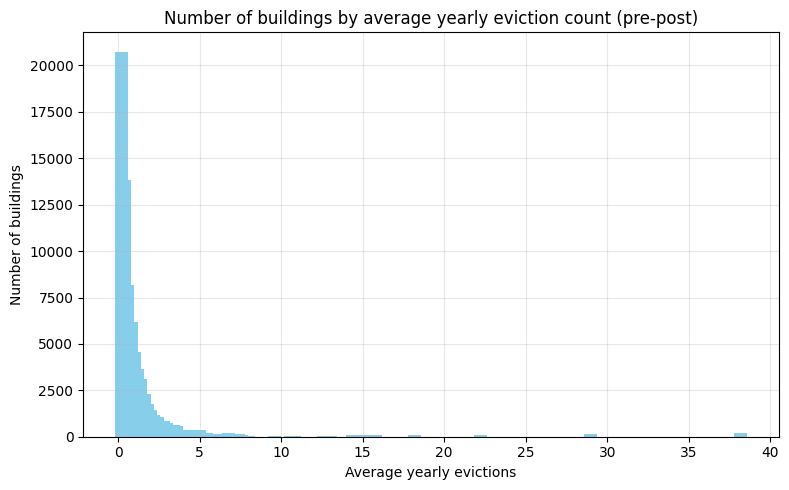

In [282]:
eviction_counts = evictions_pre_post_covid['average_year_eviction_count'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
bars = plt.bar(eviction_counts.index, eviction_counts.values, color='skyblue')

plt.title('Number of buildings by average yearly eviction count (pre-post)', fontsize=12)
plt.xlabel('Average yearly evictions')
plt.ylabel('Number of buildings')

plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# create stats
total_buildings = eviction_counts.sum()
buildings_one_eviction = eviction_counts.get(1.0, 0)
percentage_one_eviction = (buildings_one_eviction / total_buildings) * 100

In [283]:
# get the metrics first
most_common_count = eviction_counts.index[eviction_counts.argmax()]
buildings_less_equal_common = (evictions_per_building['average_year_eviction_count'] <= most_common_count).sum()
percentage_less_equal_common = (buildings_less_equal_common / total_buildings) * 100

In [284]:
most_common_count, buildings_less_equal_common, percentage_less_equal_common

(np.float64(0.2), np.int64(22908), np.float64(29.860006778070336))

In [285]:
summary_data = {'metrics': ['total buildings', 'most common eviction count (per building, per year)',
  'buildings with exactly one eviction per year', 'buildings with less than most common eviction count (per building, per year)'],
'value': [f"{total_buildings:,}", f"{most_common_count:.2f} ({eviction_counts.max():,} buildings)",
f"{buildings_one_eviction:,} ({percentage_one_eviction:.1f}%)",f"{buildings_less_equal_common:,} ({percentage_less_equal_common:.1f}%)"]}

summary_df = pd.DataFrame(summary_data)
summary_df

metrics                    value
0                                                               total buildings                   76,718
1                           most common eviction count (per building, per year)  0.20 (20,748 buildings)
2                                  buildings with exactly one eviction per year             4,572 (6.0%)
3  buildings with less than most common eviction count (per building, per year)           22,908 (29.9%)

In [286]:
evictions_covid['average_year_eviction_count'].mean(), \
evictions_pre_post_covid['average_year_eviction_count'].mean()
# not that different

(np.float64(1.1240402193784278), np.float64(1.3103339503115308))

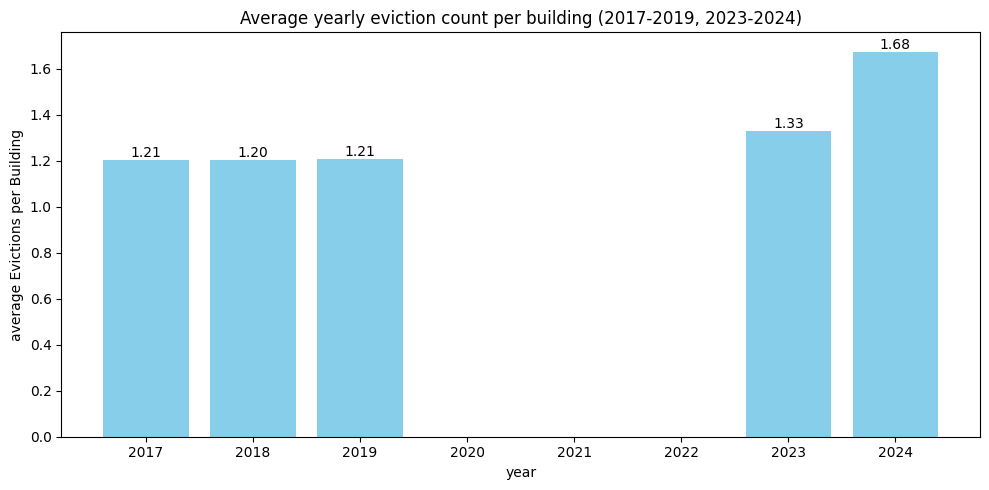

In [287]:
yearly_means = evictions_pre_post_covid.groupby('year')['average_year_eviction_count'].mean()

plt.figure(figsize=(10, 5))
bars = plt.bar(yearly_means.index, yearly_means.values, color='skyblue')

plt.title('Average yearly eviction count per building (2017-2019, 2023-2024)', fontsize=12)
plt.xlabel('year')
plt.ylabel('average Evictions per Building')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [288]:
combined_stats = {
    'metric': ['overall mean', f'maximum average ({yearly_means.idxmax()})',
        f'minimum average ({yearly_means.idxmin()})'] + [f"average for {year}" for year in yearly_means.index],
    'value': [f"{yearly_means.mean():.2f}",
  f"{yearly_means.max():.2f}",f"{yearly_means.min():.2f}"] + [f"{avg:.2f}" for avg in yearly_means.values]}

In [289]:
combined_df = pd.DataFrame(combined_stats)
combined_df

metric value
0            overall mean  1.32
1  maximum average (2024)  1.68
2  minimum average (2018)  1.20
3        average for 2017  1.21
4        average for 2018  1.20
5        average for 2019  1.21
6        average for 2023  1.33
7        average for 2024  1.68

# **Part 4 Visualize the GeoDataFrame -- Plotly and Folium**

## **Part 4.1 Plotly first pre-post covid**


In [290]:
# scatter map showing eviction counts by BBL
# a very basic and high-level visualization of each building's annual eviction during the year pre and post covid
# the outlines are clear. They are the lighter and orange ones.
fig = px.scatter_geo(evictions_pre_post_covid,
                     lat='latitude', lon='longitude',
                     color='average_year_eviction_count',
                     hover_name='bbl',
                     title="Evictions by BBL in NYC pre-post")

fig.update_geos(scope='usa', fitbounds="locations")
fig.show()

In [291]:
# not let the ones < 5 shown
evictions_filtered = evictions_pre_post_covid[evictions_pre_post_covid['average_year_eviction_count'] >= 5]
fig = px.scatter_geo(evictions_filtered,
                     lat='latitude',
                     lon='longitude',
                     color='average_year_eviction_count',
                     hover_name='bbl',
                     title="Evictions by BBL in NYC (5+ Evictions) pre-post")

fig.update_geos(scope='usa', fitbounds="locations")
fig.show()

In [292]:
# not let the ones < 10 shown
evictions_filtered = evictions_pre_post_covid[evictions_pre_post_covid['average_year_eviction_count'] >= 10]
fig = px.scatter_geo(evictions_filtered,
                     lat='latitude',
                     lon='longitude',
                     color='average_year_eviction_count',
                     hover_name='bbl',
                     title="Evictions by BBL in NYC (10+ Evictions) pre-post")

fig.update_geos(scope='usa', fitbounds="locations")
fig.show()

In [293]:
# # in case the graph does not load, it is as shown below
# # it is originally an interactive graph where if you point to a building, you get the bbl id, laititude, longitude, and
# # the annual eviction counts
# from google.colab import files
# from IPython.display import Image
# uploaded = files.upload()
# Image(filename='plotly_image.png')

In [294]:
# # save as an interactive HTML file
# pio.write_html(fig, file='evictions_map.html', auto_open=False)

#### Short summaries:  
- During covid, buildings with high evictions were drastically fewer than normal times. And the buildings with high evictions were consistent with the normal times'.[link text](https://)


## **Part 4.2 Folium pre-post covid**

In [295]:
# use folium heatmap to show the data in a better visualization
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
title_html = '''
             <div style="position: fixed;
                         top: 10px;
                         left: 50%;
                         transform: translateX(-50%);
                         z-index: 1000;
                         background-color: white;
                         padding: 10px;
                         border-radius: 5px;
                         border: 2px solid grey;
                         font-size: 16px;
                         font-weight: bold;">
                 NYC Evictions Heatmap pre post covid (all buildings with evictions per building)
             </div>
             '''
nyc_map.get_root().html.add_child(folium.Element(title_html))
heat_data = [[row['latitude'], row['longitude'], row['average_year_eviction_count']] for index, row in evictions_pre_post_covid.iterrows()]
HeatMap(heat_data, radius=10).add_to(nyc_map)

nyc_map

In [296]:
# not let the ones < 5 shown
evictions_filtered = evictions_pre_post_covid[evictions_pre_post_covid['average_year_eviction_count'] >= 5]

nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
# html
title_html = '''
             <div style="position: fixed;
                         top: 10px;
                         left: 50%;
                         transform: translateX(-50%);
                         z-index: 1000;
                         background-color: white;
                         padding: 10px;
                         border-radius: 5px;
                         border: 2px solid grey;
                         font-size: 16px;
                         font-weight: bold;">
                 NYC Evictions Heatmap pre post covid (5+ Evictions per building)
             </div>
             '''
nyc_map.get_root().html.add_child(folium.Element(title_html))
heat_data = [[row['latitude'], row['longitude'], row['average_year_eviction_count']]
             for index, row in evictions_filtered.iterrows()]

HeatMap(heat_data, radius=10).add_to(nyc_map)

nyc_map

In [297]:
# not let the ones < 10 shown
evictions_filtered = evictions_pre_post_covid[evictions_pre_post_covid['average_year_eviction_count'] >= 10]

nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
# HTML
title_html = '''
             <div style="position: fixed;
                         top: 10px;
                         left: 50%;
                         transform: translateX(-50%);
                         z-index: 1000;
                         background-color: white;
                         padding: 10px;
                         border-radius: 5px;
                         border: 2px solid grey;
                         font-size: 16px;
                         font-weight: bold;">
                 NYC Evictions Heatmap pre post covid (10+ Evictions per building)
             </div>
             '''
nyc_map.get_root().html.add_child(folium.Element(title_html))

heat_data = [[row['latitude'], row['longitude'], row['average_year_eviction_count']]
             for index, row in evictions_filtered.iterrows()]

HeatMap(heat_data, radius=10).add_to(nyc_map)

nyc_map

In [298]:
# # in case it does not load, it is as shown below
# from google.colab import files
# from IPython.display import Image
# uploaded = files.upload()
# Image(filename='heat_map.png')

#### Short summaries:
- Based on the analysis of NYC eviction data in two periods (covid in another file), there's a clear distinction between eviction patterns during and outside of the covid period. In the pre/post covid years (2017-2019, 2023-2024), evictions had a higher rate, with more buildings affected and a higher average number of evictions per building. During the Covid period (2020-2022), there was a significant decrease in eviction activity, likely due to eviction moratoriums and other protective measures implemented during the pandemic, and a decrease in rents with many residents fleeing NYC. This is interesting, as it is consistent with the phenomenon that lower rents/less competitive environment overall actually suppress evictions.

- In both periods, the majority of buildings experienced just one eviction per year, suggesting that most landlords use eviction as an occasional rather than frequent measure. However, there were some properties with notably higher eviction counts, particularly in the normal years. These concentrated areas also tend to be the regular buildings and neighborhoods who show persistent behaviors over the years.

- Foliums shows clear geo relationships with the NYC background. Plotly shows the drastic change with less background distractions.

# **Part 5 Buildings with high evictions in normal times**

In [299]:
# evictions_cleaned.columns
## didn't change

In [300]:
len(evictions_pre_post_covid.bin.unique()), \
len(evictions_covid.bin.unique())

(36029, 5326)

In [301]:
evictions_pre_post_covid.bin.dtype

dtype('int64')

In [302]:
# sort by eviction_count and extract the top 10 records based on the average_year_eviction_count column
top_bbls_pre_post = evictions_pre_post_covid[['bin', 'average_year_eviction_count']].groupby('bin').mean().sort_values(by='average_year_eviction_count', ascending=False)
top_bbls_pre_post.shape

(36029, 1)

In [303]:
top_bbls_pre_post.head(20)

average_year_eviction_count
bin                                 
3000000                         38.2
2000000                         29.0
4298968                         22.2
4000000                         18.2
2127134                         15.8
1000000                         15.2
2113629                         14.6
3326600                         14.4
2093973                         13.0
1089438                         12.6
3253907                         10.8
2113628                         10.6
2004223                          9.6
3189540                          8.0
3321834                          7.6
2013027                          7.6
3323062                          7.6
2057437                          7.4
2007988                          7.4
4047322                          7.4

In [304]:
bbls_over_10_evictions = top_bbls_pre_post[top_bbls_pre_post['average_year_eviction_count'] > 10]
bbls_over_10_evictions.shape
# 18 buildings have eviction counts larger than 10 per year on average

(12, 1)

In [305]:
bbls_over_10_evictions

average_year_eviction_count
bin                                 
3000000                         38.2
2000000                         29.0
4298968                         22.2
4000000                         18.2
2127134                         15.8
1000000                         15.2
2113629                         14.6
3326600                         14.4
2093973                         13.0
1089438                         12.6
3253907                         10.8
2113628                         10.6

### TODO:
### Some potential research questions/hypothesis include:
    - look into each of these buildings and check who the landlords are. (with the merge of BBL)
    - are they individual landlord or corporate landlords?
    - do they habitually exbihit such behavior?
    - is there a reason for the evictions besides the tenants' behavior?
    - is this related to building policy changes?
    - is this related to city-wide/neighborhood-wide changes?
### Another dataset we will be using: BBL.csv
    - pull the info of the buildings from bbl
    - since there are only 18 of them, we can have a closer look at them and then get a writeup of the landlords' background.

#### The rest of the analysis will be broken down into different notebooks

In [306]:
# save cleaned evictions data to my drive
evictions_pre_post_covid.to_csv('/content/drive/My Drive/X999/evictions_pre_post_covid.csv', index=False)

In [307]:
# save cleaned evictions data to my drive
evictions_covid.to_csv('/content/drive/My Drive/X999/evictions_covid.csv', index=False)